# <font style="color:RGB(173, 3, 252)">CSC 126 - GRAPHICS AND VISUAL COMPUTING </font>

AUTHOR: James Earl D. Cubillas, M.Sc

<h1>Neural Transfer</h1>

**Importing Packages**

In [95]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights

import copy

In [96]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

**Loading the Images**

In [97]:
imsize = 512 if torch.cuda.is_available() else 128

loader = transforms.Compose([
    transforms.Resize(imsize),
    transforms.ToTensor()])

def image_loader(image_name):
  image = Image.open(image_name)
  image = loader(image).unsqueeze(0)
  return image.to(device, torch.float)

style_img = image_loader("data/picasso.jpg")
content_img = image_loader("data/HERO.jpg")

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

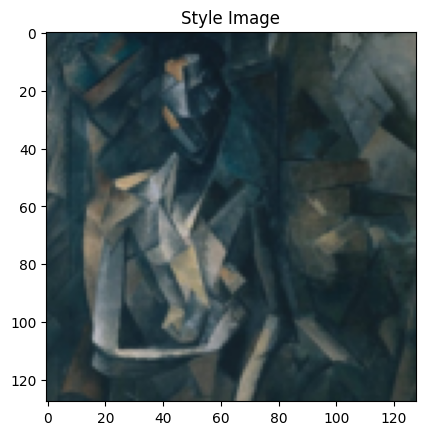

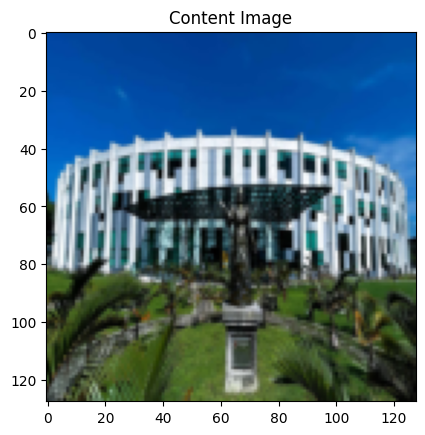

In [98]:
unloader = transforms.ToPILImage()

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

**Loss Functions**

***Content Loss***

In [99]:
class ContentLoss(nn.Module):

    def __init__(self, target):
      super(ContentLoss, self).__init__()
      self.target = target.detach()

    def forward(self, input):
       self.loss = F.mse_loss(input, self.target)
       return input

***Style Loss***

In [100]:
def gram_matrix(input):
    a, b, c, d = input.size()

    features = input.view(a * b, c * d)

    G = torch.mm(features, features.t())

    return G.div(a * b * c * d)

class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input


**Importing the Model**

In [101]:
cnn = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()

In [102]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

In [103]:
#Sequential

# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # normalization module
    normalization = Normalization(normalization_mean, normalization_std)

    # just in order to have an iterable access to or list of content/style
    # losses
    content_losses = []
    style_losses = []

    # assuming that ``cnn`` is a ``nn.Sequential``, so we make a new ``nn.Sequential``
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ``ContentLoss``
            # and ``StyleLoss`` we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

**Content Image or White noise**

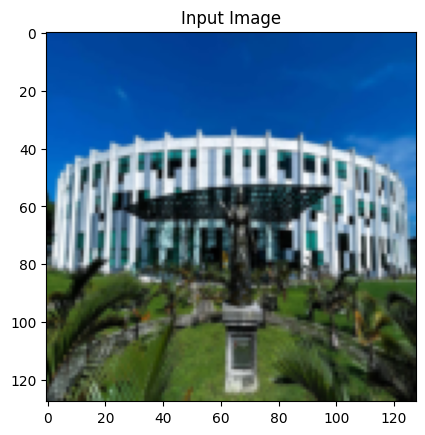

In [104]:
input_img = content_img.clone()
# if you want to use white noise by using the following code:
#
# .. code-block:: python
#
#    input_img = torch.randn(content_img.data.size())

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

**Gradient Descent**

In [105]:
def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img])
    return optimizer

**Style Transfer Function**

In [106]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=1000,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    # We also put the model in evaluation mode, so that specific layers
    # such as dropout or batch normalization layers behave correctly.
    model.eval()
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

***Run the Algorithm***

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 59.517254 Content Loss: 29.135929

run [100]:
Style Loss : 22.150589 Content Loss: 25.849323

run [150]:
Style Loss : 11.190901 Content Loss: 23.209820

run [200]:
Style Loss : 7.001465 Content Loss: 21.176743

run [250]:
Style Loss : 5.051785 Content Loss: 19.795748

run [300]:
Style Loss : 4.006089 Content Loss: 18.965490

run [350]:
Style Loss : 3.437677 Content Loss: 18.383282

run [400]:
Style Loss : 3.085271 Content Loss: 17.974480

run [450]:
Style Loss : 2.838657 Content Loss: 17.666454

run [500]:
Style Loss : 2.695469 Content Loss: 17.428101

run [550]:
Style Loss : 2.609593 Content Loss: 17.263216

run [600]:
Style Loss : 2.545301 Content Loss: 17.134342

run [650]:
Style Loss : 2.497754 Content Loss: 17.048861

run [700]:
Style Loss : 2.476050 Content Loss: 16.971468

run [750]:
Style Loss : 2.452569 Content Loss: 16.915466

run [800]:
Style Loss : 2.433633 Content Loss: 16.873442

run [850]:
Style Loss

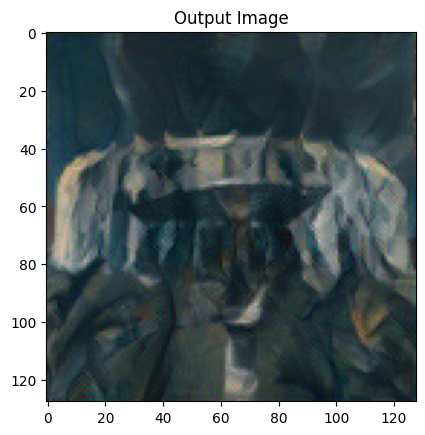

In [107]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()

***Save the Transformed Image with the Art Style***

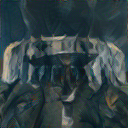

In [108]:
out_t = (output.data.squeeze())
output_img = transforms.ToPILImage()(out_t)
output_img.save('output.png')
output_img